In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as math
import scipy as sp
import time
from scipy.integrate import solve_ivp
from cholesky_01 import cholesky
from tqdm import tqdm, trange

In [2]:
def pred_prey(t, population, params):
    prey, predator = population
    dpdt = params[0] * prey - params[1] * prey * predator
    drdt = -params[2] * predator + params[3] * prey * predator
    return [dpdt, drdt] 

def pred_prey_model(params, t_eval):
    z0 = [params[4], params[5]] 
    def ode(t, z):
        return pred_prey(t, z, params)  
    t_span = (t_eval[0], t_eval[-1])
    sol = solve_ivp(ode, t_span, z0, t_eval=t_eval, method='RK45')
    return sol

def log_likelihood(params, t, model, data):
    try:
        solution = model(params, t)
        if not solution.success:
            return -np.inf

        y_model = solution.y.T
        min_len = min(data.shape[0], y_model.shape[0])

        # clamp to positive for log
        data_prey = np.maximum(data[:min_len, 0], 1e-8)
        data_pred = np.maximum(data[:min_len, 1], 1e-8)
        model_prey = np.maximum(y_model[:min_len, 0], 1e-8)
        model_pred = np.maximum(y_model[:min_len, 1], 1e-8)

        # log-residuals
        log_resid_prey = np.log(data_prey) - np.log(model_prey)
        log_resid_pred = np.log(data_pred) - np.log(model_pred)

        # estimate sigma from log-residuals (pooled for both species)
        sigma_prey = np.std(log_resid_prey)
        sigma_pred = np.std(log_resid_pred)
        sigma = np.mean([sigma_prey, sigma_pred]) + 1e-6  # avoid zero

        # lognormal likelihood
        loglike_prey = -0.5 * np.sum((log_resid_prey) ** 2 / sigma ** 2)
        loglike_pred = -0.5 * np.sum((log_resid_pred) ** 2 / sigma ** 2)
        loglike_prey -= min_len * np.log(sigma * np.sqrt(2 * np.pi))
        loglike_pred -= min_len * np.log(sigma * np.sqrt(2 * np.pi))

        return loglike_prey + loglike_pred
    except Exception as e:
        print(f"Error in lognormal log-likelihood: {e}")
        return -np.inf

def log_prior(params, theta):
    if len(params) != 6:
        print('Rejected: wrong length', params)
        return -np.inf
    if np.any(params <= 0):
        print("Rejected: negative param", params)
        return -np.inf

# truncated Normal priors for positivity
# means are taken from OLS estimator done in referenced paper
# standard deviations are chosen to be relatively wide
    alpha_prior = np.log(sp.stats.truncnorm.pdf(params[0], a=-theta[0]/0.5, b=np.inf, loc=theta[0], scale=0.5))

    beta_prior = np.log(sp.stats.truncnorm.pdf(params[1], a=-theta[1]/0.05, b=np.inf, loc=theta[1], scale=0.05))

    gamma_prior = np.log(sp.stats.truncnorm.pdf(params[2], a=-theta[2]/0.5, b=np.inf, loc=theta[2], scale=0.5))

    delta_prior = np.log(sp.stats.truncnorm.pdf(params[3], a=-theta[3]/0.05, b=np.inf, loc=theta[3], scale=0.05))

    
    h0_prior = np.log(sp.stats.truncnorm.pdf(params[4], a=-theta[4]/5.0,b=np.inf,loc=theta[4], scale=5.0))

    l0_prior = np.log(sp.stats.truncnorm.pdf(params[5], a=-theta[5]/5.0, b=np.inf, loc=theta[5], scale=5.0))

    if not all(np.isfinite([alpha_prior, beta_prior, gamma_prior, delta_prior, h0_prior, l0_prior])):
        return -np.inf

    return alpha_prior + beta_prior + gamma_prior + delta_prior + h0_prior + l0_prior

def log_posterior(params, t, model, data, theta):
    like = log_likelihood(params, t, model, data)
    prior = log_prior(params, theta)
    return like + prior

# transition kernel for Metropolis-Hastings
# uses a Cholesky decomposition of the covariance matrix for proposal generation

def prop(current, C):
    z = np.random.randn(6)
    proposal = current + 0.8 * C @ z 
    # ensure all parameters remain positive
    proposal = np.maximum(proposal, 0.001) 
    return proposal

def acceptance_prob(current, proposal, t, model, data, theta):
    try:
        lp_proposal = log_posterior(proposal, t, model, data, theta)
        lp_current = log_posterior(current, t, model, data, theta)
        if not np.isfinite(lp_proposal) or not np.isfinite(lp_current):
            return 0 
        beta = lp_proposal - lp_current
        alpha = min(1, np.exp(beta))
        return alpha
    except:
        return 0

def metropolis_hastings(data, initial, model, t, theta, iterations=1000):
    data_values = data[['prey', 'pred']].values 
    df_for_cholesky = pd.DataFrame(data_values, columns=['prey', 'pred']) #Cholesky function takes dataframes only
    
    try:
        C = cholesky(df_for_cholesky, initial, t, pred_prey)
        print("Cholesky decomposition successful")
    except Exception as e:
        print(f"Cholesky failed: {e}")
        print("Using identity matrix as fallback")
        C = np.eye(6) * 0.01  # fallback to small diagonal matrix
    
    samples = [initial.copy()]
    current = initial.copy()
    accepted = 0
    start = time.time()

    for i in trange(iterations, desc="MCMC Progress"):
        proposal = prop(current, C)
        alpha = acceptance_prob(current, proposal, t, model, data_values, theta)
        if alpha > 0 and np.random.rand() < alpha:
            current = proposal.copy()
            accepted += 1
        samples.append(current.copy())
    total_time = time.time() - start
    print(f"Final acceptance rate: {accepted/iterations:.3f}")
    print(f"Total runtime: {total_time:.1f} seconds")
    return np.array(samples)

In [3]:
#create dataset

data = pd.DataFrame(dict(
    prey = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4, 
                 27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7]),
    pred = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
                8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6]),
    ))
print(data.head()) 

   prey  pred
0  30.0   4.0
1  47.2   6.1
2  70.2   9.8
3  77.4  35.2
4  36.3  59.4


### Burn in

In [4]:
np.random.seed(42)
model = pred_prey_model
t_eval = np.linspace(0,20,21)
theta = np.array([0.48, 0.02, 0.93, 0.03, 34.91, 3.86])
initial = np.array([0.48, 0.02, 0.93, 0.03, 34.91, 3.86]) # from the paper
samples = metropolis_hastings(data, initial, model, t_eval, theta, iterations=5000)

Cholesky decomposition successful


MCMC Progress: 100%|██████████| 5000/5000 [00:37<00:00, 133.05it/s]

Final acceptance rate: 0.897
Total runtime: 37.6 seconds


### Adaptive

In [5]:
def adaptive_mcmc(data, initial, model, t_eval, theta, total_iterations=1000, update_interval=100):
    
    data_values = data[['prey', 'pred']].values
    df_for_cholesky = pd.DataFrame(data_values, columns=['prey', 'pred'])
    
    try:
        C = cholesky(df_for_cholesky, initial, t_eval, pred_prey)
        print("Cholesky decomposition successful")
    except Exception as e:
        print(f"Cholesky failed: {e}")
        print("Using identity matrix as fallback")
        C = np.eye(6) * 0.01  # fallback to small diagonal matrix
    
    samples = [initial.copy()]
    current = initial.copy()
    accepted = 0
    covariance_updates = 0
    
    start = time.time()
    
    for i in trange(total_iterations, desc="Adaptive MCMC Progress"):
        
        if i > 0 and i % update_interval == 0 and len(samples) > 10:
            print(f"\nUpdating covariance at iteration {i}")
            
            # every update interval, we recompute the covariance matrix

            samples_array = np.array(samples)
            
            try:
                emp_cov = np.cov(samples_array.T)
                
                # add regularization for numerical stability
                emp_cov += 1e-6 * np.eye(emp_cov.shape[0])
                
                C = np.linalg.cholesky(emp_cov)
                covariance_updates += 1
                
                print(f"Covariance updated successfully (update #{covariance_updates})")
                print(f"Covariance diagonal: {np.diag(emp_cov)}")
                
            except np.linalg.LinAlgError:
                print(f"Cholesky decomposition failed at iteration {i}, keeping previous C")
            except Exception as e:
                print(f"Error updating covariance: {e}, keeping previous C")
        
        proposal = prop(current, C)

        alpha = acceptance_prob(current, proposal, t_eval, model, data_values, theta)
        
        if alpha > 0 and np.random.rand() < alpha:  # simplified acceptance criterion
            current = proposal.copy()
            accepted += 1
        
        samples.append(current.copy())
    
    total_time = time.time() - start
    
    print(f"\nAdaptive MCMC Complete!")
    print(f"Final acceptance rate: {accepted/total_iterations:.3f}")
    print(f"Total covariance updates: {covariance_updates}")
    print(f"Total runtime: {total_time:.1f} seconds")
    
    return np.array(samples), C

In [6]:
burn_in_samples = 1000
adaptive_initial = np.mean(samples[-burn_in_samples:], axis=0)
adaptive_theta = theta  # keep theta as the original prior means, not sample means

print("Original initial guess:", initial)
print("New initial guess from MCMC (mean of last {} samples):".format(burn_in_samples))
print(adaptive_initial)
print("Difference from original:", adaptive_initial - initial)

Original initial guess: [4.800e-01 2.000e-02 9.300e-01 3.000e-02 3.491e+01 3.860e+00]
New initial guess from MCMC (mean of last 1000 samples):
[4.79864951e-01 2.49881166e-02 8.72816029e-01 2.80546209e-02
 3.30141726e+01 5.40745830e+00]
Difference from original: [-1.35049101e-04  4.98811660e-03 -5.71839712e-02 -1.94537910e-03
 -1.89582740e+00  1.54745830e+00]


In [7]:
adaptive_samples, final_C = adaptive_mcmc(data, adaptive_initial, pred_prey_model, t_eval, adaptive_theta,
                                         total_iterations=5000, update_interval=500)

print(f"\nAdaptive samples shape: {adaptive_samples.shape}")
print("Parameter means from adaptive MCMC:")
param_names = ['a (prey growth)', 'b (predation)', 'c (predator death)', 'd (predator efficiency)', 'Prey Initial', 'Predator Initial']
for i, name in enumerate(param_names):
    print(f"{name}: {np.mean(adaptive_samples[2500:, i]):.4f} ± {np.std(adaptive_samples[2500:, i]):.4f}")

print(f"\nFinal covariance matrix (Cholesky factor) shape: {final_C.shape}")
print("Final covariance diagonal values:")
print(np.diag(final_C @ final_C.T))

Cholesky decomposition successful


Adaptive MCMC Progress:  10%|█         | 516/5000 [00:04<00:33, 132.41it/s]


Updating covariance at iteration 500
Covariance updated successfully (update #1)
Covariance diagonal: [1.39148316e-04 1.22665880e-06 4.41277981e-04 1.53803008e-06
 2.65304578e-01 3.58935682e-02]


Adaptive MCMC Progress:  20%|██        | 1018/5000 [00:08<00:26, 148.31it/s]


Updating covariance at iteration 1000
Covariance updated successfully (update #2)
Covariance diagonal: [1.50057436e-03 7.87719260e-06 3.13440379e-03 6.70600701e-06
 1.86933041e+00 1.01363970e-01]


Adaptive MCMC Progress:  30%|███       | 1515/5000 [00:11<00:23, 150.98it/s]


Updating covariance at iteration 1500
Covariance updated successfully (update #3)
Covariance diagonal: [1.74455839e-03 8.30587611e-06 3.35170499e-03 7.04238701e-06
 2.49098814e+00 1.41206383e-01]


Adaptive MCMC Progress:  40%|████      | 2019/5000 [00:15<00:20, 147.76it/s]


Updating covariance at iteration 2000
Covariance updated successfully (update #4)
Covariance diagonal: [2.64880333e-03 1.22963434e-05 4.90422668e-03 8.52120389e-06
 2.92988826e+00 1.49996217e-01]


Adaptive MCMC Progress:  50%|█████     | 2519/5000 [00:18<00:17, 142.43it/s]


Updating covariance at iteration 2500
Covariance updated successfully (update #5)
Covariance diagonal: [2.83254942e-03 1.21833287e-05 4.96654805e-03 8.84162651e-06
 3.49787258e+00 1.59500696e-01]


Adaptive MCMC Progress:  60%|██████    | 3014/5000 [00:22<00:14, 139.32it/s]


Updating covariance at iteration 3000
Covariance updated successfully (update #6)
Covariance diagonal: [2.89012894e-03 1.25961259e-05 5.14113867e-03 9.56658446e-06
 3.97430490e+00 1.59732082e-01]


Adaptive MCMC Progress:  71%|███████   | 3526/5000 [00:25<00:10, 142.19it/s]


Updating covariance at iteration 3500
Covariance updated successfully (update #7)
Covariance diagonal: [2.85271125e-03 1.20420582e-05 5.00723102e-03 9.27122764e-06
 3.91627083e+00 1.77757381e-01]


Adaptive MCMC Progress:  80%|████████  | 4025/5000 [00:29<00:06, 142.64it/s]


Updating covariance at iteration 4000
Covariance updated successfully (update #8)
Covariance diagonal: [3.04198574e-03 1.28022509e-05 5.65001811e-03 9.88545409e-06
 4.43138678e+00 1.76724976e-01]


Adaptive MCMC Progress:  90%|█████████ | 4523/5000 [00:33<00:03, 150.19it/s]


Updating covariance at iteration 4500
Covariance updated successfully (update #9)
Covariance diagonal: [3.00964238e-03 1.26622522e-05 5.88478647e-03 1.00753363e-05
 4.56730508e+00 1.92242266e-01]


Adaptive MCMC Progress: 100%|██████████| 5000/5000 [00:36<00:00, 137.22it/s]


Adaptive MCMC Complete!
Final acceptance rate: 0.338
Total covariance updates: 9
Total runtime: 36.4 seconds

Adaptive samples shape: (5001, 6)
Parameter means from adaptive MCMC:
a (prey growth): 0.5331 ± 0.0585
b (predation): 0.0268 ± 0.0036
c (predator death): 0.8187 ± 0.0869
d (predator efficiency): 0.0245 ± 0.0034
Prey Initial: 34.6655 ± 2.3273
Predator Initial: 5.6876 ± 0.4960

Final covariance matrix (Cholesky factor) shape: (6, 6)
Final covariance diagonal values:
[3.00964238e-03 1.26622522e-05 5.88478647e-03 1.00753363e-05
 4.56730508e+00 1.92242266e-01]


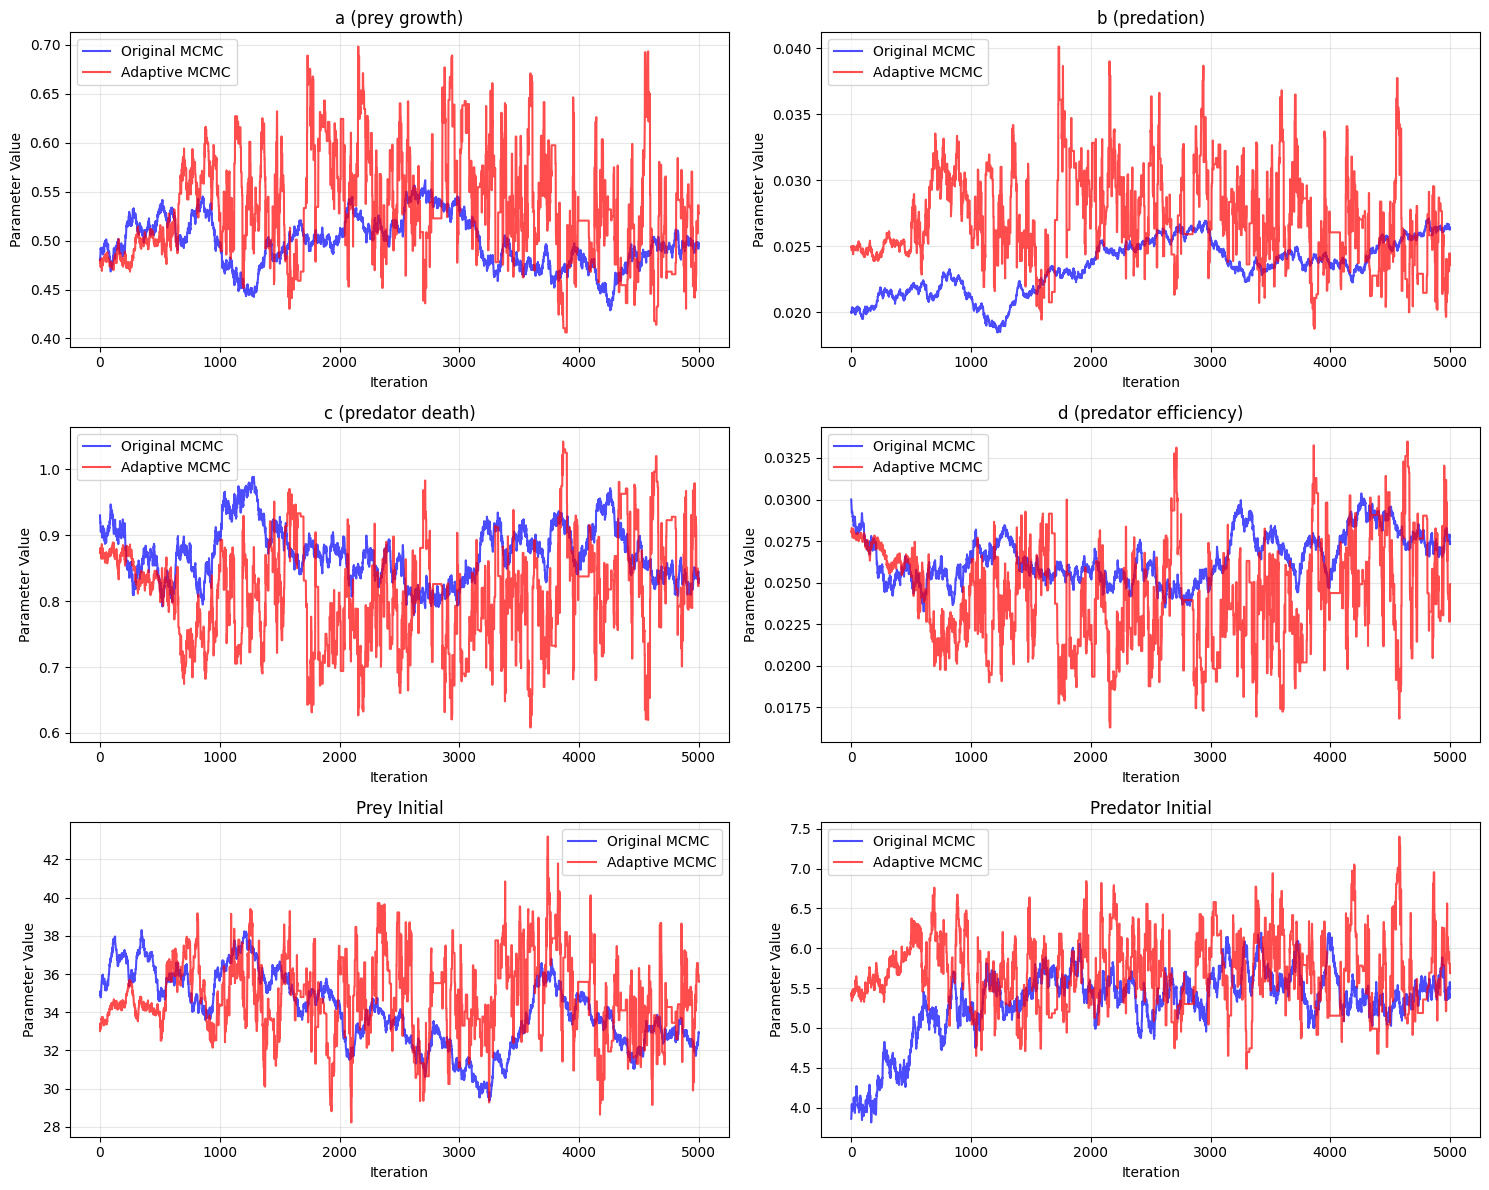


Comparison of parameter estimates (using last 500 samples):
Parameter		Original MCMC		Adaptive MCMC
-----------------------------------------------------------------
a (prey growth)     	0.4970±0.0267	0.5406±0.0566
b (predation)       	0.0237±0.0019	0.0274±0.0036
c (predator death)  	0.8719±0.0429	0.8048±0.0822
d (predator efficiency)	0.0265±0.0015	0.0239±0.0032
Prey Initial        	33.7979±1.8159	34.8788±2.2165
Predator Initial    	5.4424±0.2613	5.7109±0.4704


In [8]:
#comparing original and adaptive MCMC samples
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
param_names = ['a (prey growth)', 'b (predation)', 'c (predator death)', 'd (predator efficiency)', 'Prey Initial', 'Predator Initial']

for i in range(6):
    ax = axes[i//2, i%2]
    
    ax.plot(samples[:, i], alpha=0.7, label='Original MCMC', color='blue')
    
    ax.plot(adaptive_samples[:, i], alpha=0.7, label='Adaptive MCMC', color='red')
    
    ax.set_title(f'{param_names[i]}')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Parameter Value')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nComparison of parameter estimates (using last 500 samples):")
print("Parameter\t\tOriginal MCMC\t\tAdaptive MCMC")
print("-" * 65)
for i, name in enumerate(param_names):
    orig_mean = np.mean(samples[500:, i])
    orig_std = np.std(samples[500:, i])
    adapt_mean = np.mean(adaptive_samples[500:, i])
    adapt_std = np.std(adaptive_samples[500:, i])
    print(f"{name:<20}\t{orig_mean:.4f}±{orig_std:.4f}\t{adapt_mean:.4f}±{adapt_std:.4f}")

### Fixed using adaptive correlation and mean params

In [9]:
#taking the final covariance from the adaptive MCMC and using it for a lot more samples
def fixed_covariance_mcmc(data, initial, model, t_eval, theta, C_fixed, iterations=20000):
    
    data_values = data[['prey', 'pred']].values
    
    samples = [initial.copy()]
    current = initial.copy()
    accepted = 0
    
    start = time.time()
    
    
    for i in trange(iterations, desc="Fixed Covariance MCMC"):
        proposal = prop(current, final_C)  
        alpha = acceptance_prob(current, proposal, t_eval, model, data_values, theta)
        
        if alpha > 0 and np.random.rand() < alpha:
            current = proposal.copy()
            accepted += 1
        
        samples.append(current.copy())
    
    total_time = time.time() - start
    print(f"Final acceptance rate: {accepted/iterations:.3f}")
    print(f"Total runtime: {total_time:.1f} seconds")
    
    return np.array(samples)

In [10]:
long_initial = np.mean(adaptive_samples[-500:], axis=0) # take the fianl state of apadtive for intitial guess

long_samples = fixed_covariance_mcmc(data, long_initial, pred_prey_model, t_eval, 
                                    adaptive_theta, final_C, iterations=50000) #run for a long time

print("Parameter means from long MCMC (using last 10,000 samples):")
for i, name in enumerate(param_names):
    print(f"{name}: {np.mean(long_samples[10000:, i]):.4f} ± {np.std(long_samples[10000:, i]):.4f}")

Fixed Covariance MCMC: 100%|██████████| 50000/50000 [07:18<00:00, 113.94it/s] 

Final acceptance rate: 0.241
Total runtime: 438.8 seconds
Parameter means from long MCMC (using last 10,000 samples):
a (prey growth): 0.5450 ± 0.0598
b (predation): 0.0276 ± 0.0040
c (predator death): 0.8001 ± 0.0858
d (predator efficiency): 0.0239 ± 0.0033
Prey Initial: 34.4212 ± 2.4441
Predator Initial: 5.8499 ± 0.5175


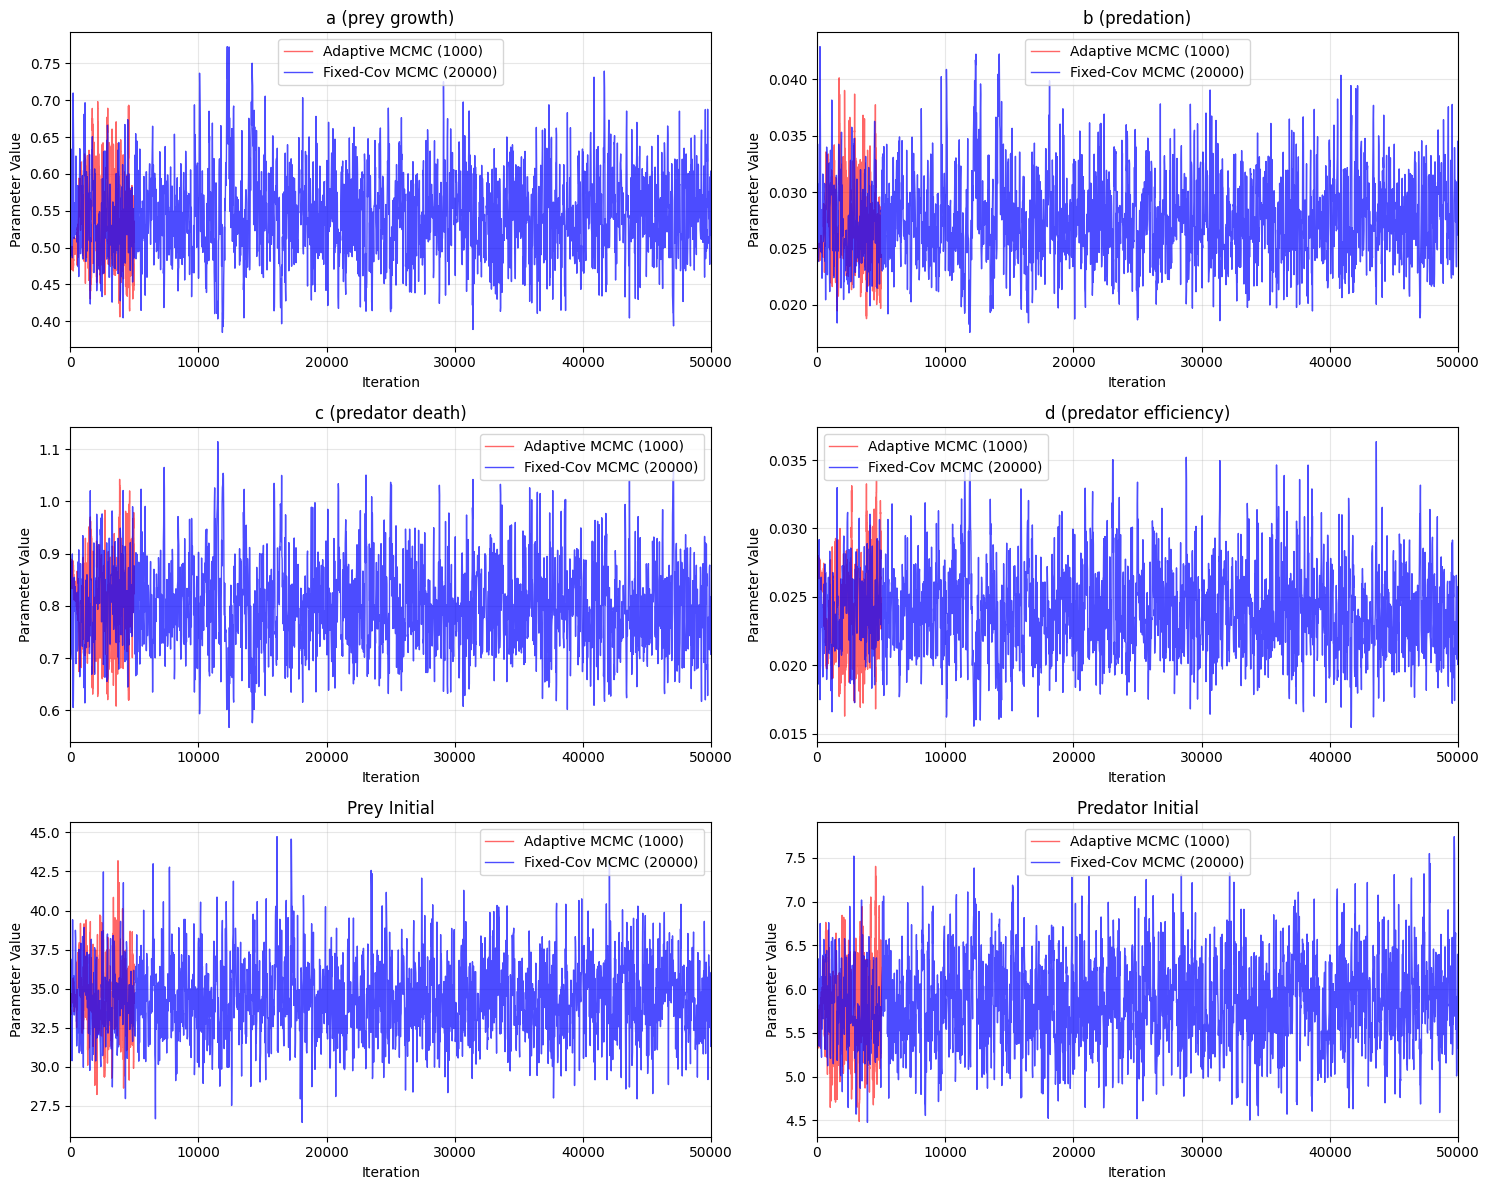


Comparison of parameter estimates from all three methods:
Parameter		Original (1000)		Adaptive (1000)		Long Fixed-Cov (50000)
-----------------------------------------------------------------------------------------------
a (prey growth)     	0.4970±0.0267		0.5406±0.0566		0.5450±0.0598
b (predation)       	0.0237±0.0019		0.0274±0.0036		0.0276±0.0040
c (predator death)  	0.8719±0.0429		0.8048±0.0822		0.8001±0.0858
d (predator efficiency)	0.0265±0.0015		0.0239±0.0032		0.0239±0.0033
Prey Initial        	33.7979±1.8159		34.8788±2.2165		34.4212±2.4441
Predator Initial    	5.4424±0.2613		5.7109±0.4704		5.8499±0.5175

Effective sample sizes:
Original MCMC: 4501 samples
Adaptive MCMC: 4501 samples
Long Fixed-Cov MCMC: 40001 samples


In [11]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  # comparing all of the chains

for i in range(6):
    ax = axes[i//2, i%2]    
    ax.plot(adaptive_samples[:, i], alpha=0.6, label='Adaptive MCMC (1000)', color='red', linewidth=1)
    
    subsample_indices = np.arange(0, len(long_samples), 20) 
    ax.plot(subsample_indices, long_samples[subsample_indices, i], alpha=0.7, 
            label='Fixed-Cov MCMC (20000)', color='blue', linewidth=1)
    ax.set_xlim(0, 50000)
    ax.set_title(f'{param_names[i]}')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Parameter Value')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('real_chains.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

print("\nComparison of parameter estimates from all three methods:")
print("Parameter\t\tOriginal (1000)\t\tAdaptive (1000)\t\tLong Fixed-Cov (50000)")
print("-" * 95)

for i, name in enumerate(param_names):
    orig_mean = np.mean(samples[500:, i])
    orig_std = np.std(samples[500:, i])
    
    adapt_mean = np.mean(adaptive_samples[500:, i])
    adapt_std = np.std(adaptive_samples[500:, i])
    
    long_mean = np.mean(long_samples[10000:, i])
    long_std = np.std(long_samples[10000:, i])
    
    print(f"{name:<20}\t{orig_mean:.4f}±{orig_std:.4f}\t\t{adapt_mean:.4f}±{adapt_std:.4f}\t\t{long_mean:.4f}±{long_std:.4f}")

print(f"\nEffective sample sizes:")
print(f"Original MCMC: {len(samples[500:])} samples")
print(f"Adaptive MCMC: {len(adaptive_samples[500:])} samples") 
print(f"Long Fixed-Cov MCMC: {len(long_samples[10000:])} samples")

### Plot trajectories with predicted behavior

Generating 95% confidence intervals for t=0 to t=40...


CI trajectories: 100%|██████████| 2000/2000 [00:08<00:00, 230.61it/s]


Generating 95% prediction intervals for t=0 to t=40...


PI trajectories: 100%|██████████| 2000/2000 [00:08<00:00, 237.45it/s]


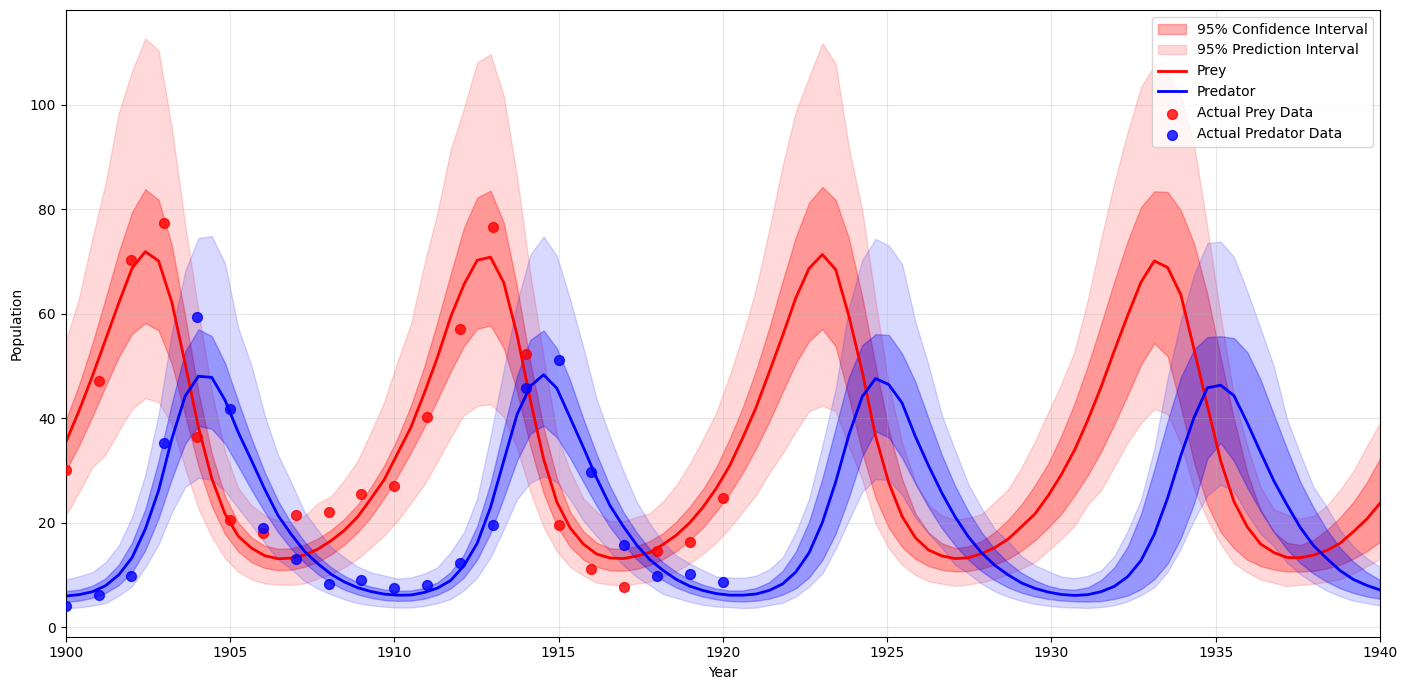

In [12]:
burn_in_long = 1000
post_burn_long = long_samples[burn_in_long:]

n_samples_uncertainty = 2000
thin_step = max(1, post_burn_long.shape[0] // n_samples_uncertainty)
indices = np.arange(0, post_burn_long.shape[0], thin_step)[:n_samples_uncertainty]

# Time grid for full interval
t_full = np.linspace(0, 40, 100)

prey_traj_conf = []
pred_traj_conf = []
prey_traj_pred = []
pred_traj_pred = []

print("Generating 95% confidence intervals for t=0 to t=40...")
for idx in tqdm(indices, desc="CI trajectories"):
    params = post_burn_long[idx]
    sol = pred_prey_model(params, t_full)
    if sol.success:
        prey_traj_conf.append(sol.y[0])
        pred_traj_conf.append(sol.y[1])
best_params = np.mean(post_burn_long, axis=0)
sol = pred_prey_model(best_params, t_eval)
data_prey = np.maximum(data['prey'].values, 1e-8)
data_pred = np.maximum(data['pred'].values, 1e-8)
model_prey = np.maximum(sol.y[0], 1e-8)
model_pred = np.maximum(sol.y[1], 1e-8)
log_resid_prey = np.log(data_prey) - np.log(model_prey)
log_resid_pred = np.log(data_pred) - np.log(model_pred)
sigma_prey = np.std(log_resid_prey)
sigma_pred = np.std(log_resid_pred)
sigma = np.mean([sigma_prey, sigma_pred]) + 1e-6

print("Generating 95% prediction intervals for t=0 to t=40...")
for idx in tqdm(indices, desc="PI trajectories"):
    params = post_burn_long[idx].copy()
    sol = pred_prey_model(params, t_full)
    if sol.success:
        prey_traj_pred.append(sol.y[0] * np.exp(np.random.normal(0, sigma, size=sol.y[0].shape)))
        pred_traj_pred.append(sol.y[1] * np.exp(np.random.normal(0, sigma, size=sol.y[1].shape)))

prey_traj_conf = np.array(prey_traj_conf)
pred_traj_conf = np.array(pred_traj_conf)
prey_traj_pred = np.array(prey_traj_pred)
pred_traj_pred = np.array(pred_traj_pred)
prey_mean = np.mean(prey_traj_pred, axis=0)
pred_mean = np.mean(pred_traj_pred, axis=0)
# compute 95% CI
prey_ci_lower, prey_ci_upper = np.percentile(prey_traj_conf, [2.5, 97.5], axis=0)
pred_ci_lower, pred_ci_upper = np.percentile(pred_traj_conf, [2.5, 97.5], axis=0)

# compute 95% PI
prey_pi_lower, prey_pi_upper = np.percentile(prey_traj_pred, [2.5, 97.5], axis=0)
pred_pi_lower, pred_pi_upper = np.percentile(pred_traj_pred, [2.5, 97.5], axis=0)

plt.figure(figsize=(14, 7))

year_full = t_full + 1900
year_eval = np.linspace(0, 20, 21) + 1900

# Prey
plt.fill_between(year_full, prey_ci_lower, prey_ci_upper, color='red', alpha=0.3, label = "95% Confidence Interval")
plt.fill_between(year_full, prey_pi_lower, prey_pi_upper, color='red', alpha=0.15, label = "95% Prediction Interval")
plt.plot(year_full, prey_mean, color='red', linewidth=2, label='Prey')


# Predator
plt.fill_between(year_full, pred_ci_lower, pred_ci_upper, color='blue', alpha=0.3)
plt.fill_between(year_full, pred_pi_lower, pred_pi_upper, color='blue', alpha=0.15)
plt.plot(year_full, pred_mean, color='blue', linewidth=2, label='Predator')


# Data points (only for t=0-20)
plt.scatter(year_eval, data['prey'].values, color='red', s=50, alpha=0.8, label='Actual Prey Data', zorder=5)
plt.scatter(year_eval, data['pred'].values, color='blue', s=50, alpha=0.8, label='Actual Predator Data', zorder=5)

plt.savefig('real_bayesian.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xlim(1900,1940) 
plt.show()


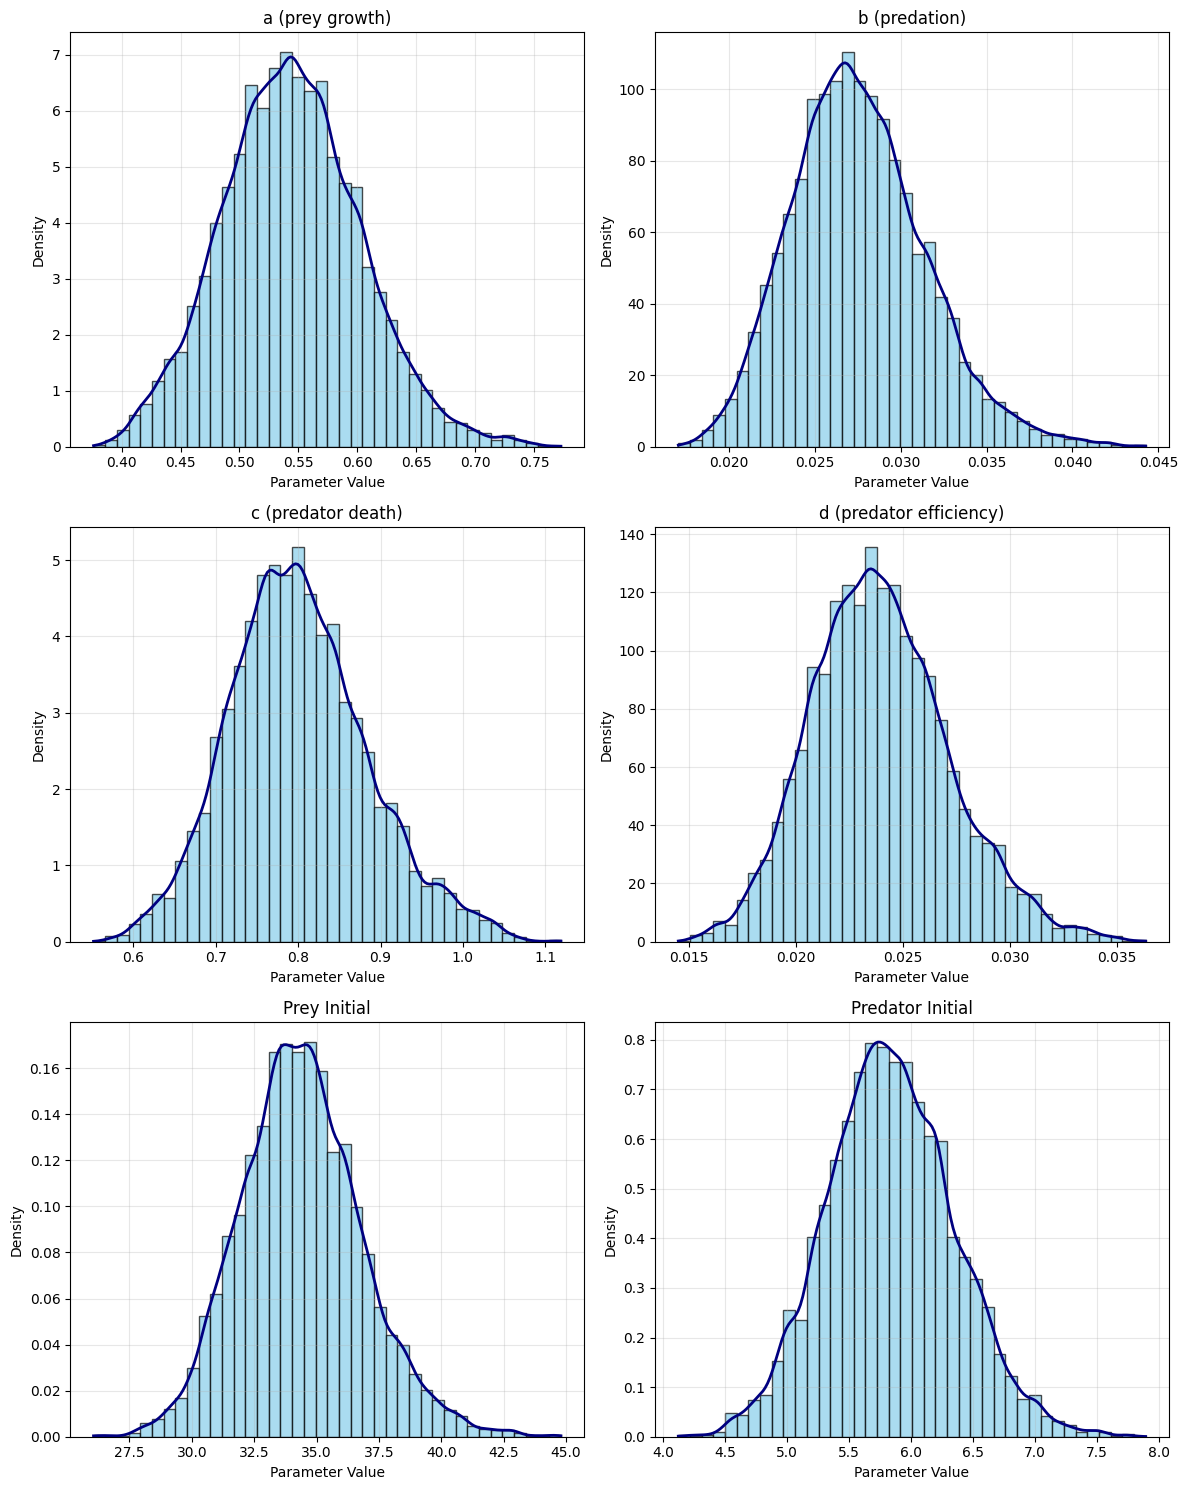

In [13]:
import scipy.stats as stats #plotting posterior distributions

fig, axes = plt.subplots(3, 2, figsize=(12, 15))
param_names = ['a (prey growth)', 'b (predation)', 'c (predator death)', 'd (predator efficiency)', 'Prey Initial', 'Predator Initial']

for i, ax in enumerate(axes.flat):
    data_i = post_burn_long[:, i]
    counts, bins, _ = ax.hist(data_i, bins=40, color='skyblue', edgecolor='black', alpha=0.7, density=True)
    kde = stats.gaussian_kde(data_i)
    x_vals = np.linspace(np.min(data_i), np.max(data_i), 200)
    ax.plot(x_vals, kde(x_vals), color='navy', linewidth=2)
    ax.set_title(f'{param_names[i]}')
    ax.set_xlabel('Parameter Value')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('real_posterior.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

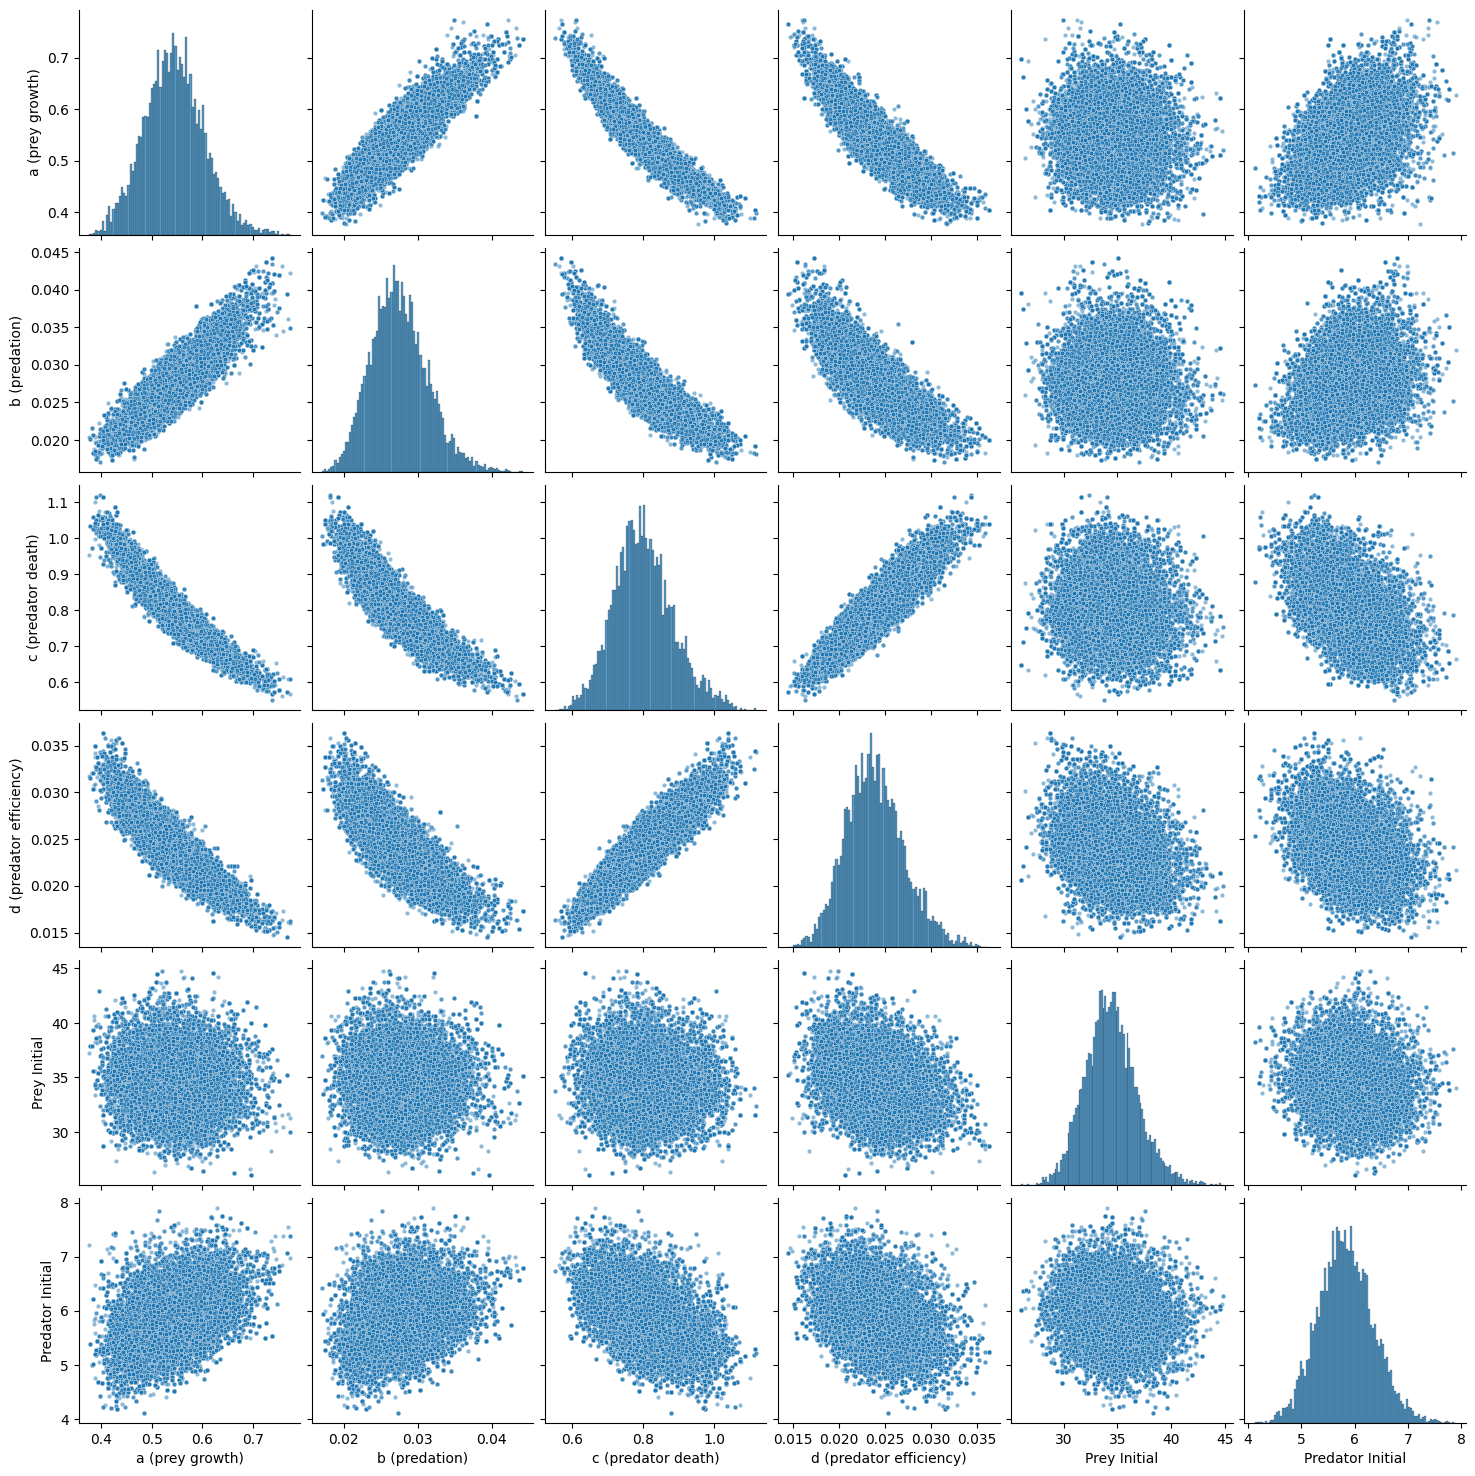

In [14]:
import seaborn as sns #plotting correlation plots

param_names_corr = ['a (prey growth)', 'b (predation)', 'c (predator death)', 'd (predator efficiency)', 'Prey Initial', 'Predator Initial']
df_params = pd.DataFrame(post_burn_long, columns=param_names_corr)

sns.pairplot(df_params, diag_kind='hist', plot_kws={'alpha':0.5, 's':10})
plt.savefig('real_covariance.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [16]:
np.save('real_samples.npy', post_burn_long) #save samples for control uncertainty